In [1]:
import warnings
import numpy as np
import pandas as pd
import random
import matplotlib
import matplotlib.pyplot as plt
import itertools
import csv
from IPython.display import clear_output
%matplotlib inline

In [2]:
warnings.filterwarnings('ignore')
matplotlib.style.use('ggplot')

In [3]:
def generationSquawk(input, listOfPoints):

    '''Функция возвращает список порядковых номеров столбцов "важных" признаков в соответствии с двоичным кодом сквока\n
    это используется для понимания, где нужно сгенерировать импульс\n
    P.S. также добавляется преамбула и постамбула\n

    Parameters
    ----------
        input : двоичный код сквока с учетом позиции Х\n
        listOfPoints : список номеров "важных" столбцов (взято из exсel)
    '''

    impPoints = list()  # список из порядковых номеров, учавствующих в построении импульса из двоичного сигнала 

    for i in range(len(input)):
        if input[i] == '1':
            impPoints.append(listOfPoints[i+1])
    impPoints.insert(0,2) # добавление преамбулы
    impPoints.append(83)  # добавление постамбулы

    return impPoints

def generationSignal(impPoints, squawk, noiseDF,pool):

    '''Функция возвращает массив [1х86] с сигналом, импульсы которого записаны на датасет шума\n
    пример импульса для формирования сигнала берется из оригинального датасета\n

    Parameters
    ----------
        impPoints : dtype = list, сквок в двоичном виде\n
        squawk : dtype = int, номер сквока\n
        noiseDF : dtype = pandas.DataFrame, датафрейм шума размерностью [1х86]\n
        pool : dtype = dict, оригинальный датасет'''
    
    noiseArray = noiseDF.copy()
    for i in range(len(impPoints)):
        valuesPool = pool[random.randint(0,1999)]
        noiseArray[0,impPoints[i]-1] = valuesPool[0]
        noiseArray[0,impPoints[i]] = valuesPool[1]
        noiseArray[0,impPoints[i]+1] = valuesPool[2]
    noiseArray[0][0] = squawk
    noiseArray.shape = -1
    return noiseArray


def to_Dex(input):

    '''Функция выполняет декодирование двоичного сигнала сквока и возвращает десятичное число\n

    Parameters
    ----------
        input : dtype = int, двоичное число\n'''

    bin = str()
    input = str(input)

    n1 = int(input[1])*1 + int(input[3])*2 + int(input[5])*4
    n2 = int(input[7])*1 + int(input[9])*2 + int(input[11])*4
    n3 = int(input[0])*1 + int(input[2])*2 + int(input[4])*4
    n4 = int(input[8])*1 + int(input[10])*2 + int(input[12])*4
    
    bin = int(str(n1) + str(n2) + str(n3) + str(n4))

    return bin

def createCombinations():   # WARNING! словарь без пре- и постамбулы 
    
    '''Функция возвращает словарь с комбинациями двоичного сигнала без повторений\n
    ключ словаря - номер сквока в десятичной системе\n
    значение ключа - двоичный код десятичного ключа\n
    P.S. по сути соблюдается декодирование двоичного кода сквока'''
    
    dictOfSeq = dict()
    
    for i in itertools.product('01', repeat=12):
        s = ''.join(i)
        s = s[:6] + "0" + s[6:] # вставка позиции Х, которая всегда равна нулю
        dictOfSeq[to_Dex(s)] = s
    
    return dictOfSeq

def createDictOfSquawk(quantity, listOfPoints, dictOfCombinations, poolSignal, poolNoise):

    '''Функция возвращает словарь размером в 8192000 записи. В словаре формируются 4096 варианта сквока причем каждого варианта по 2000
    
    Parameters
    ----------
        listOfPoints : dtype = list, лист с "важными" столбцами из excel\n
        dictOfCombinations : dtype = dict, словарь со всеми возможными комбинациями сквока\n
        poolSignal : dtype = dict, набор импульсов в кол-ве 2000, взятых с оригинального датасета с сигналами\n
        poolNoise : dtype = dict, словарь с 2000 вариантами разных дорожек сплошного шум по всем столбцам'''
        
    dictOfSquawk = dict()

    count = 0
    n = 0

    for i in dictOfCombinations:    
        for j in range(quantity):  
            signalArray = generationSignal(generationSquawk(dictOfCombinations[i],listOfPoints),
                                            i,
                                            poolNoise[random.randint(0,quantity-1)],
                                            poolSignal)
            dictOfSquawk[n] = signalArray
            n += 1
        count += 1
        clear_output(wait=True)
        print("status:\t", count/4096 * 100, "%")

    return dictOfSquawk 

def writeDictToCSV(csv_file,csv_columns,data_list):

    '''Функция записывает словарь в csv файл
    
    Parameters
    ----------
        csv_file : dtype = str, путь куда csv запишется + указывается имя файла\n
        csv_columns : dtype = list, названия колонок\n
        data_list : dtype = like-array, данные для записи в формате массива'''
    
    with open(csv_file, 'w',newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(csv_columns)
        for data in data_list:
            writer.writerow(data)
    
    return 

def getPoolImpulse(data):

    '''Функция возвращает словарь с набором импульсов в кол-ве 2000, взятых с оригинала
    
    Parameters
    ----------
        data : dtype = pandas.DataFrame, оригинальный Data_Signal.cvs'''
        
    pool = dict()
    for i in range(len(data.iloc[:2000,1:])):
        pool[i] = [data.iloc[i,7], data.iloc[i,8], data.iloc[i,9]]
    return pool

def getPoolNoise(data):

    '''Функция словарь с дорожкой шума, взятых с Data_Noise.csv
    
    Parameters
    ----------
        data : dtype = pandas.DataFrame, оригинальный Data_Noise.cvs'''
        
    pool = dict()
    for i in range(len(data.iloc[:2000,1:])):
        pool[i] = pd.DataFrame(noise.iloc[i,:].values.reshape(1,-1), columns=noise.columns).values # сплошной шум по всем столбцам
    return pool

def showSignal(data, n, label):
    '''Функция рисует график сквока

    Parameters
    ----------
        data : dtype = pandas.DataFrame, набор данных в pandas\n
        n : dtype = int, номер\n
        label : dtype = str\n
            "sequence" - вывести график по порядковому номеру (n)\n
            "squawk" - вывести график по номеру (n) сквока (будет взят первый сквок из 2000)'''

    if label == 'sequence':
        data.iloc[n,1:].plot(label="squawk " +
                 str(int(data['label'].iloc[n])) +
                 " or " +
                 str(dictOfCombinations[int(data['label'].iloc[n])]))
        plt.legend()
        plt.show()
    if label == 'squawk':
        data.loc[data['label']==n].iloc[0,1:].plot(label="squawk " +
                 str(int(data.loc[data['label']==n].iloc[0,0])) +
                 " or " +
                 str(dictOfCombinations[int(data.loc[data['label']==n].iloc[0,0])]))
        plt.legend()
        plt.show()
    

In [4]:
# время выполнения ~3 мин

data_signal = pd.read_csv("DataSet_Signal.csv", delimiter=';')
noise = pd.read_csv("DataSet_Noise.csv")

# создание словаря размером 8192000 записей
# ключ - порядковый номер записи, значение - массив [1х86] содержащий label сквока и 85 его значений

listOfPoints = [2, 8, 14, 19, 25, 31, 37, 43, 49, 54, 60, 66, 72, 77, 83]  # порядковый номер столбцов в датасете соответствующий информационным импульсам (взят из excel)
dictOfCombinations = createCombinations()   # формирование всех возможных комбинаций
poolSignal = getPoolImpulse(data_signal)    # набор импульсов в кол-ве 2000, взятых с DataSet_Signal.csv
poolNoise = getPoolNoise(noise)             # набор дорожек шума в кол-ве 2000, взятых с DataSet_Noise.csv

dictOfSquawk = createDictOfSquawk(200, listOfPoints, dictOfCombinations, poolSignal, poolNoise) # созданный словарь размером 8192000 записей

status:	 100.0 %


In [5]:
name = 'Squawk_x200.csv'
path = '.\\out\\' + name # куда сохранить csv

In [6]:
# время выполнения ~10 мин

# сохранение словаря в csv файл, размер csv ~6 ГБ

writeDictToCSV(path,list(data_signal.columns),dictOfSquawk.values())

In [7]:
# освободить память

del(dictOfSquawk)
del(poolSignal)
del(poolNoise)
del(listOfPoints)

In [8]:
# созданный csv с 8192000 записями => 4096 вариантов сквока * 2000 количество повторений одного вида сигнала
data = pd.read_csv(path)

In [9]:
data.shape

(819200, 86)

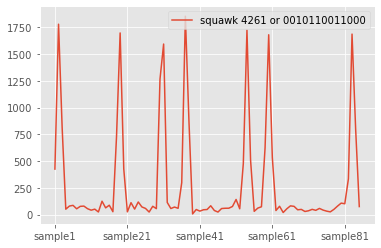

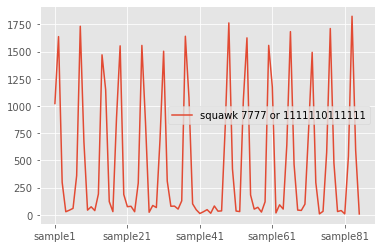

In [9]:
n_sequece = 1456456  # порядковый номер (всего записей => от 0 до 8191999)
n_squawk = 7777      # номер сквока

showSignal(data,n_sequece,label="sequence")
showSignal(data,n_squawk,label="squawk")

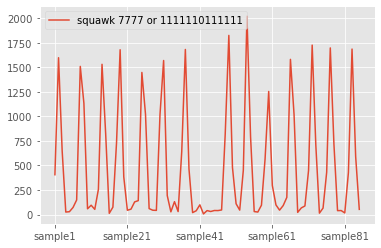

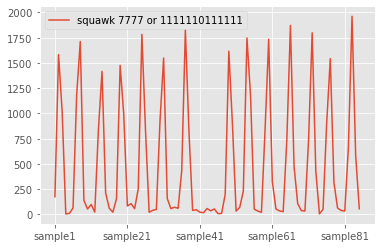

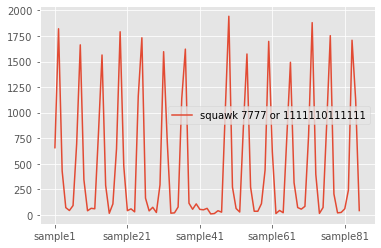

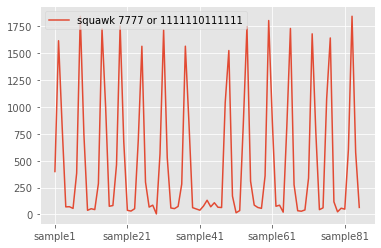

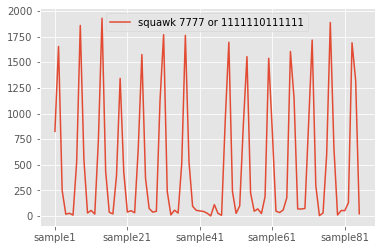

In [10]:
# посмотреть и убедиться, что импульсы одного и того же сквока действительно разные 

for i in range (8191994,8191999):
    showSignal(data,i,label="sequence")

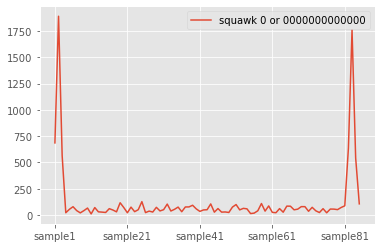

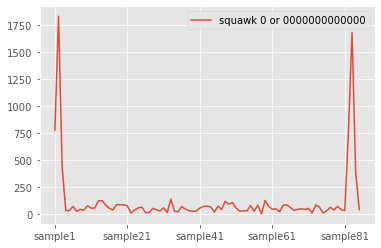

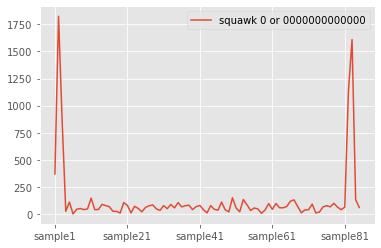

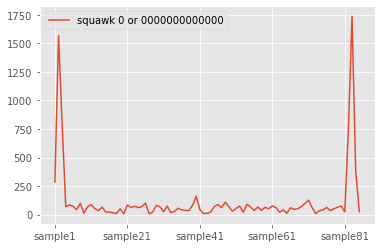

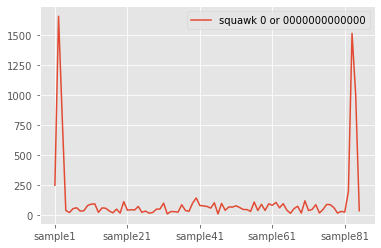

In [11]:
# посмотреть и убедиться, что шум одного и того же сквока действительно разные 

for i in range (0,5):
    showSignal(data,i,label="sequence")